In [1]:
import numpy as np
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import multivariate_normal

In [2]:
import RL_formulation as rl

import numpy as np
import matplotlib.pyplot as plt

environments = []

for i in range(4):
    env = rl.Environment()
    environments.append(env)



In [3]:
import pickle

In [23]:

file_params = open('best_params.pkl', 'rb')
best_params = pickle.load(file_params)
file_params.close()

In [24]:
best_params

array([-0.24640216, -7.55809545,  1.00287223, ...,  6.91168714,
        1.67413777, -0.89419091])

In [4]:
import agent_arch as arch

In [5]:

agent = arch.Agent()

print("agent shapes: ", agent.model_shapes)


agent shapes:  [(50, 99), (50,), (50, 50), (50,), (10, 50), (10,)]


In [7]:
agent.updateParams(best_params)

In [8]:
best_params /= np.linalg.norm(best_params)

In [18]:
agent.updateParams(best_params)

In [6]:
s = environments[0].reset(24)
action = agent.getAction(s)
print(action)

[ 0.11576642  0.02977598  0.14547514  0.0407966  -0.17587845 -0.09967883
 -0.05858073 -0.11671477 -0.0430139   0.12353427]


In [7]:
s0 = environments[0].reset(24)
a0 = agent.getAction(s0)

s1 = environments[1].reset(24)
a1 = agent.getAction(s1)

s2 = environments[2].reset(24)
a2 = agent.getAction(s2)

s3 = environments[3].reset(24)
a3 = agent.getAction(s3)

actions1 = np.array([a0, a1, a2, a3])
actions1 = torch.from_numpy(actions1).float()

states = torch.from_numpy(np.array([s0, s1, s2, s3])).float()

actions2 = agent.model(states)

print(actions1)
print()
print(actions2)

tensor([[ 0.1292,  0.0197,  0.2316,  0.0877, -0.1955, -0.0065,  0.0102, -0.0862,
         -0.0491,  0.0773],
        [ 0.0861,  0.0627,  0.1694,  0.0420, -0.2093, -0.0435, -0.0213, -0.1451,
         -0.0503,  0.1212],
        [ 0.0260,  0.1019,  0.1606,  0.0009, -0.1652, -0.0649, -0.0137, -0.0822,
          0.0017,  0.1472],
        [ 0.1641,  0.0549,  0.1013,  0.0718, -0.1476, -0.1028,  0.0136, -0.1133,
         -0.1117,  0.1313]])

tensor([[ 0.1348,  0.0246,  0.1806,  0.0718, -0.1714, -0.0691, -0.0367, -0.1218,
         -0.0676,  0.1230],
        [ 0.0961,  0.0687,  0.1533,  0.0642, -0.1744, -0.0612, -0.0401, -0.1136,
         -0.0641,  0.1362],
        [ 0.0829,  0.0618,  0.1545,  0.0212, -0.1901, -0.0678, -0.0509, -0.1018,
         -0.0581,  0.1358],
        [ 0.1208,  0.0703,  0.1586,  0.0633, -0.1422, -0.0616, -0.0296, -0.1313,
         -0.0748,  0.1105]], grad_fn=<TanhBackward0>)


In [8]:
# agent.optimizer.zero_grad()

# #guessies = self.model(states)
# loss = agent.criterion(actions2, actions1)
# loss.backward()
# agent.optimizer.step()
# print(loss.item())

In [36]:
def generate_session(env, agent, num_of_steps=24): # не сессия, а эпизод, но осталось из старых задачек про лунар
    
    [[states, actions, total_reward], 
     [desired_total_Production_in_dinamics,
      total_Production_in_dinamics,
      run_out_of_elecs]]                              = rl.generate_episode(env, agent, num_of_steps=num_of_steps)
    
    assert total_reward < 0
    
    neg_log_loss = -np.log(-total_reward)
            
    return [states, actions, neg_log_loss]

In [34]:
%%time

[[states, actions, total_reward], 
     [desired_total_Production_in_dinamics,
      total_Production_in_dinamics,
      run_out_of_elecs]]                              = rl.generate_episode(env, agent, num_of_steps=24)

CPU times: user 912 ms, sys: 17 µs, total: 912 ms
Wall time: 910 ms


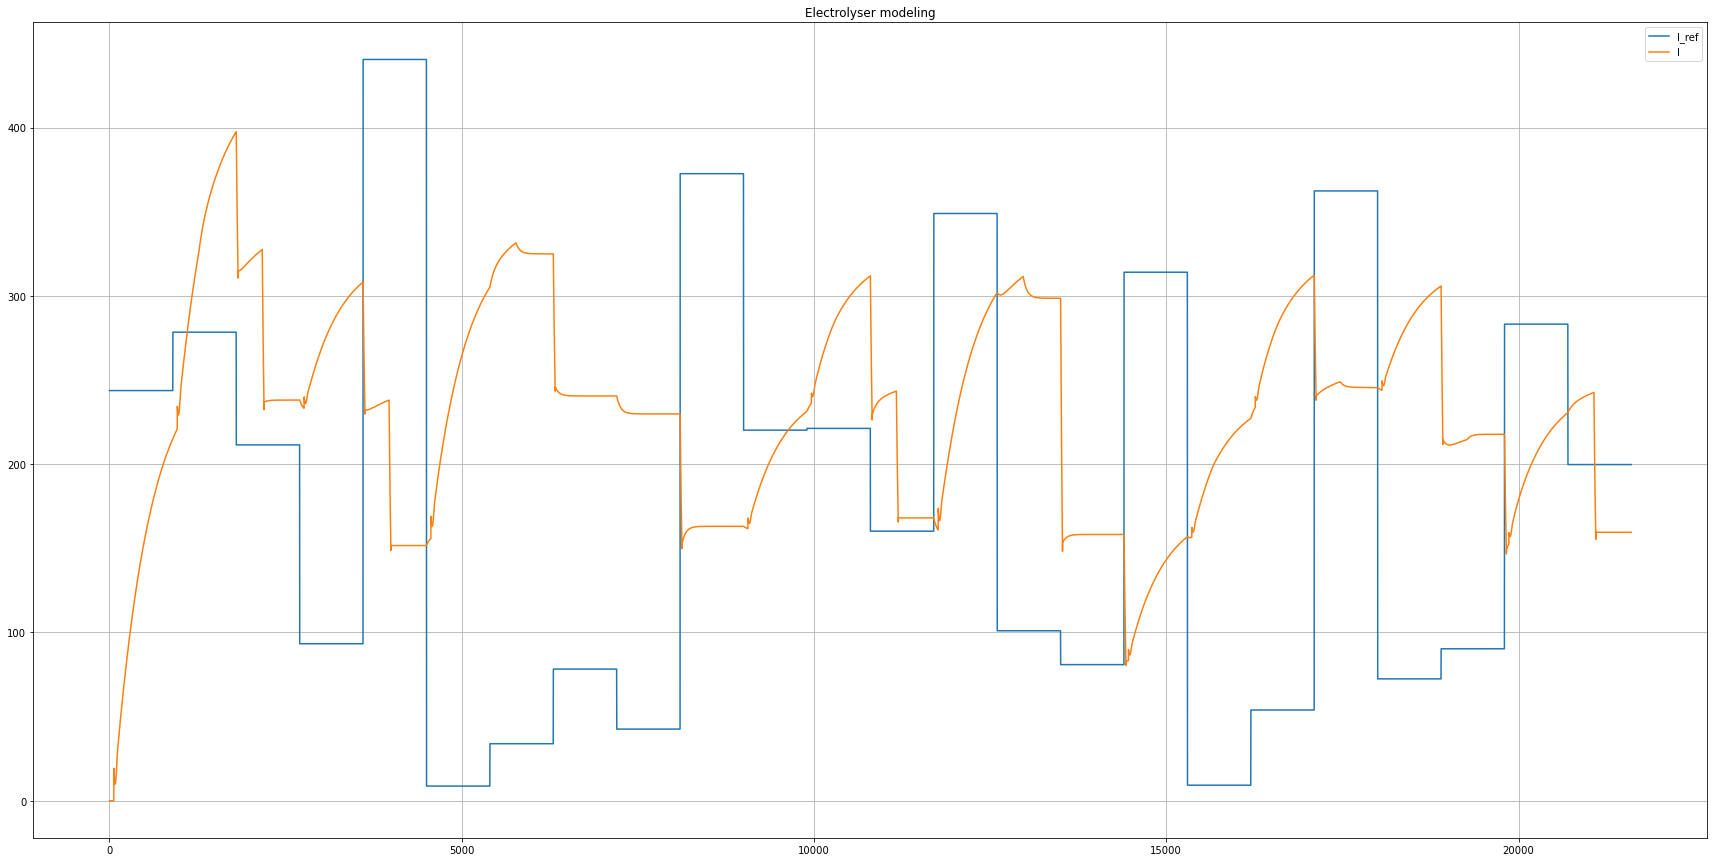

In [35]:
plt.figure(figsize=(30, 15))
plt.title("Electrolyser modeling")
plt.plot(desired_total_Production_in_dinamics, label='I_ref')
plt.plot(total_Production_in_dinamics, label='I')

plt.legend()
plt.grid(visible=True)

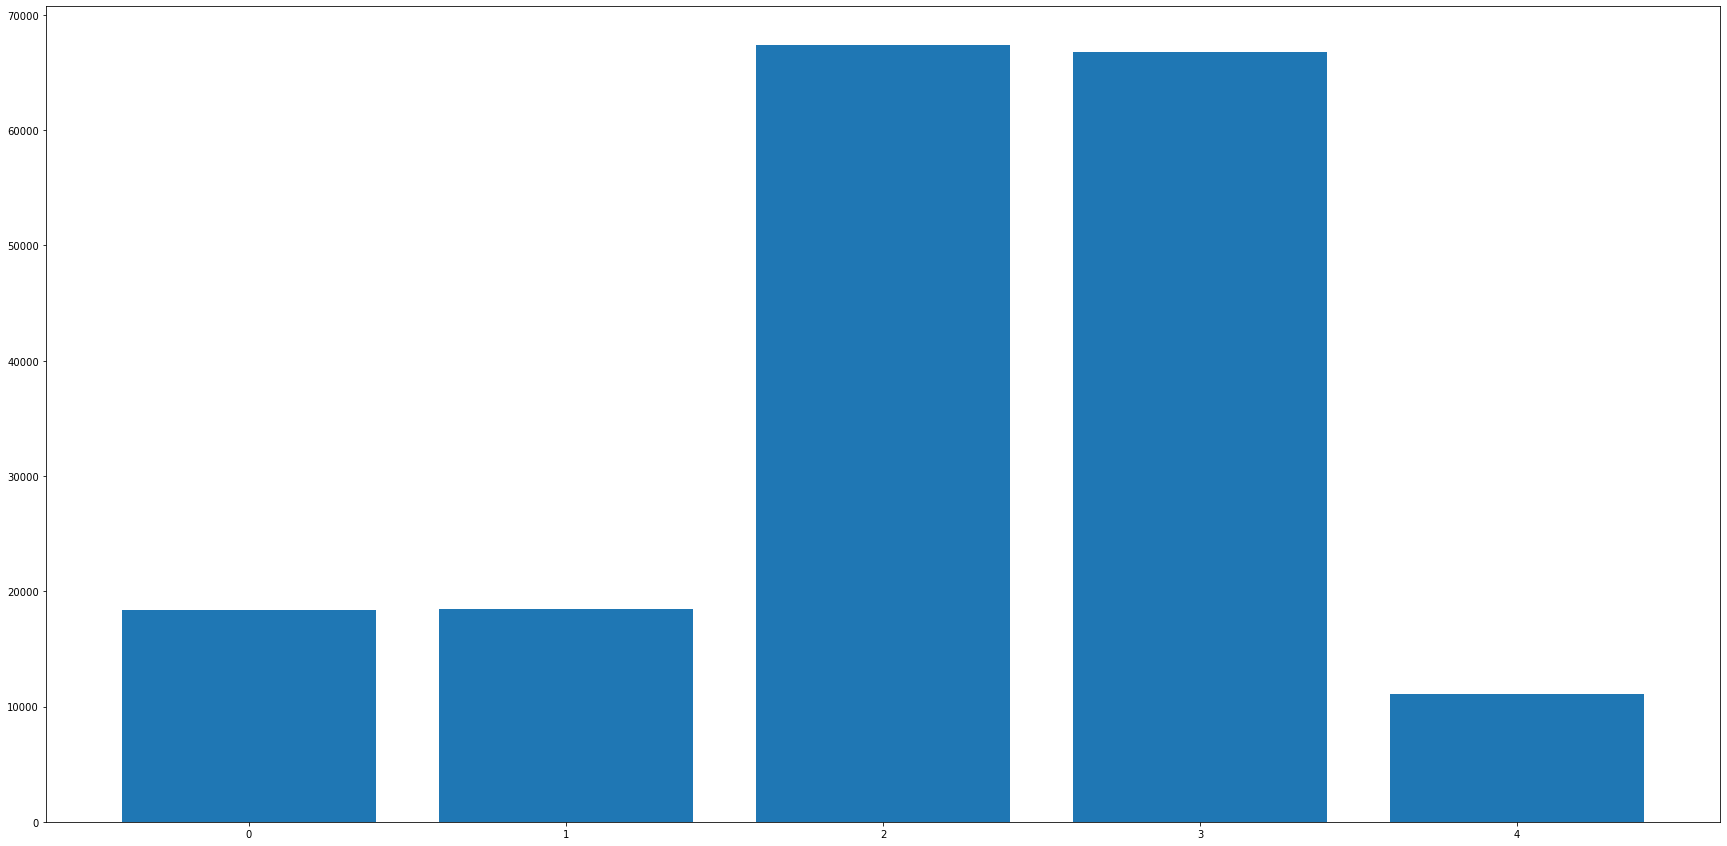

In [37]:
num_elecs = 5
names = list(range(num_elecs))
values = run_out_of_elecs

plt.figure(figsize=(30, 15))
plt.bar(names, values)
plt.show()

### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [38]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = []
    elite_actions = []
    
    for i, r in enumerate(rewards_batch):
        if r > reward_threshold:
            
            for t in range(len(states_batch[i])):
                
                elite_states.append(states_batch[i][t])
                elite_actions.append(actions_batch[i][t])
    
    
    return np.array(elite_states), np.array(elite_actions)

# Training loop
Generate sessions, select N best and fit to those.

In [39]:
from IPython.display import clear_output

def show_progress(sigma, len_sessions_buffer, rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f, len_sessions_buffer=%.3f, sigma=%.3f" % (mean_reward, threshold, len_sessions_buffer, sigma))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [40]:
import joblib

mean reward = -3.472, threshold=-3.655, len_sessions_buffer=100.000, sigma=0.010


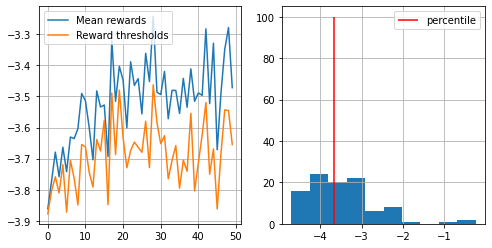

CPU times: user 12min 19s, sys: 4.73 s, total: 12min 24s
Wall time: 22min 38s


In [61]:

%%time

n_episodes = 100
percentile = 60 # 80 70
log = []

episodes_buffer = []

# best_mean_reward = -400

for i in range(50):
    # generate new sessions
    
    episodes = joblib.Parallel(n_jobs=-1)(joblib.delayed(generate_session)(env, agent, num_of_steps=24) for _ in range(n_episodes))
    
    episodes_buffer.extend(episodes)
        
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*episodes_buffer))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)

    agent.fit(elite_states, elite_actions)
    
    show_progress(agent.sigma, len(episodes_buffer), rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)])
    
    if ((i+1) % 1) == 0:
        episodes_buffer = []
        
    mean_reward = np.mean(rewards_batch)
    
    # best_mean_reward = max(best_mean_reward, mean_reward)
    
#     if mean_reward > up: # 0.1 0.01 02
#         agent.sigma -= 0.001 # 0.0045
        
#         up += 10
        

    if mean_reward > 50:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        if mean_reward > 500:
            break 
            
            

In [51]:
agent.optimizer = optim.Adam(params=agent.model.parameters(), lr=0.02)

In [52]:
agent.sigma = 0.01

# Results

In [62]:
%%time

[[states, actions, total_reward], 
     [desired_total_Production_in_dinamics,
      total_Production_in_dinamics,
      run_out_of_elecs]]                              = rl.generate_episode(env, agent, num_of_steps=24)

CPU times: user 915 ms, sys: 3.98 ms, total: 919 ms
Wall time: 918 ms


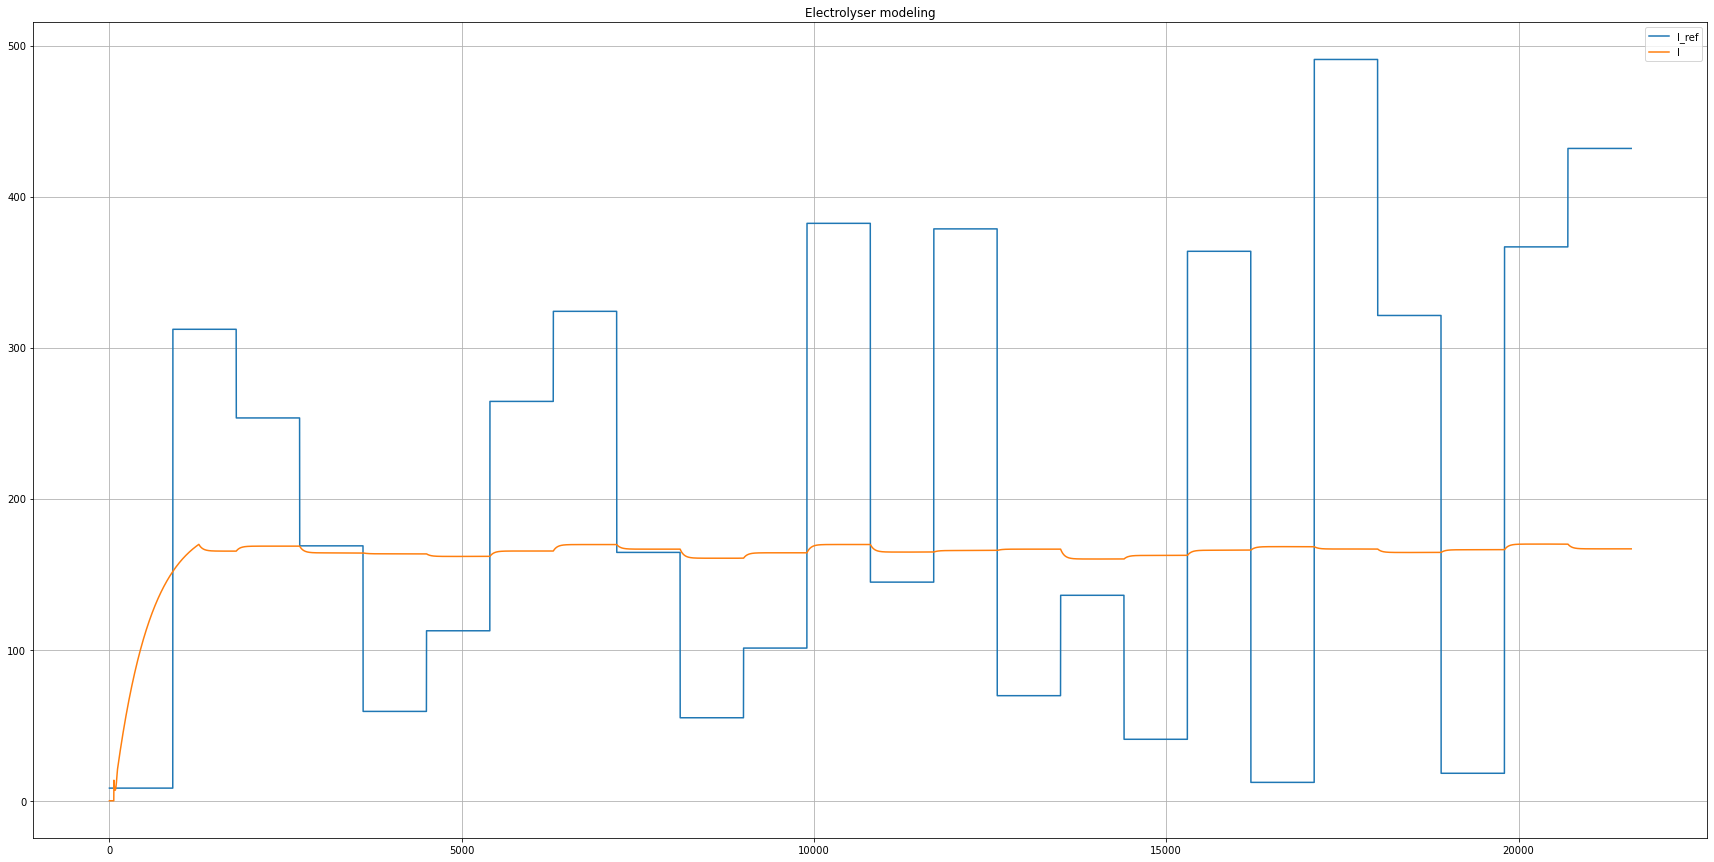

In [63]:
plt.figure(figsize=(30, 15))
plt.title("Electrolyser modeling")
plt.plot(desired_total_Production_in_dinamics, label='I_ref')
plt.plot(total_Production_in_dinamics, label='I')

plt.legend()
plt.grid(visible=True)

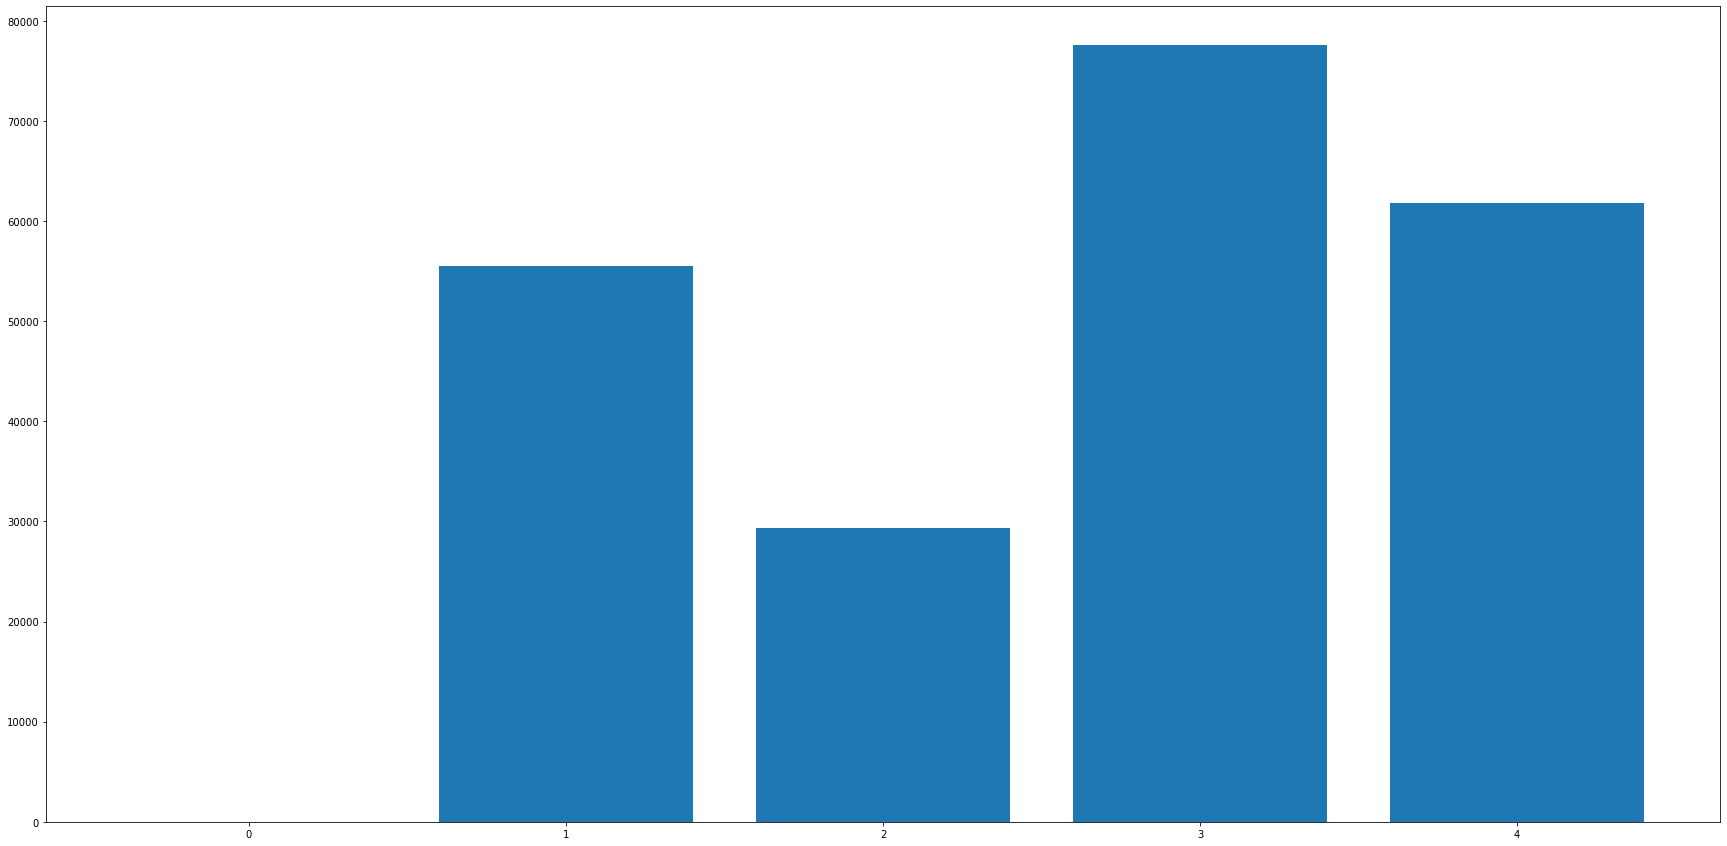

In [60]:
num_elecs = 5
names = list(range(num_elecs))
values = run_out_of_elecs

plt.figure(figsize=(30, 15))
plt.bar(names, values)
plt.show()

In [50]:
agent.model.parameters()
for param in agent.model.parameters():
    print(param.data)
    print("=======================================")
    

tensor([[ 0.1159,  0.1138, -0.0498,  ...,  0.0471,  0.0365, -0.0067],
        [ 0.0356,  0.0666, -0.0483,  ..., -0.0726, -0.0400, -0.0528],
        [ 0.0103,  0.0384,  0.0642,  ..., -0.0700, -0.0512, -0.0889],
        ...,
        [ 0.0019,  0.0002,  0.0642,  ...,  0.0002, -0.0063,  0.0976],
        [ 0.0841,  0.0240,  0.0188,  ...,  0.0102, -0.0430, -0.0282],
        [-0.0052, -0.1131, -0.0859,  ..., -0.0985,  0.0691, -0.0445]])
tensor([-0.0684,  0.0486,  0.0416, -0.0871, -0.0467, -0.0324,  0.0415,  0.0188,
         0.0113,  0.0366, -0.0805, -0.0141,  0.0628,  0.0598,  0.1343, -0.0396,
         0.0719, -0.0826, -0.0020, -0.0619,  0.0917, -0.0168, -0.0507, -0.0444,
        -0.0057, -0.1165,  0.0828, -0.0392, -0.0679, -0.0049, -0.0201, -0.1022,
         0.0892,  0.0393,  0.0797,  0.0106, -0.0029, -0.0882,  0.0445, -0.0611,
         0.0409, -0.1107, -0.0578, -0.0523, -0.1049,  0.0012, -0.0746,  0.0650,
         0.0225, -0.0525])
tensor([[-0.0598,  0.0941, -0.1315,  ..., -0.0861,  0.0673,

In [22]:
import pickle

file_model = open('serialised_data_CEM/best_solution.pkl', 'wb')

pickle.dump(agent, file_model)

file_model.close()

FileNotFoundError: [Errno 2] No such file or directory: 'serialised_data_CEM/best_solution.pkl'